In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stat
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from multiprocessing import Pool
from scipy import stats
from scipy.optimize import curve_fit
import pandas as pd
import seaborn as sns
import statsmodels
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks
import pickle
import numpy.linalg as nl

# Lineplots first!
## Odd is Accuracy Even is Speed

## 0 1 are sudden

In [2]:
def lineplots(data, block, first, last):
    traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data)))

    for i in range(first,last):
        plt.plot(traj['x'][0][i][0], traj['y'][0][i][0])


In [3]:
interact(lineplots, data = widgets.ToggleButtons(options = range(1000, 1060)), block = widgets.IntSlider(max = 11, min = 0, value = 0, step = 1),
        first = widgets.IntSlider(max = 63, min = 0, value = 0, step = 1), last = widgets.IntSlider(max = 64, min = 1, value = 1, step = 1))

interactive(children=(ToggleButtons(description='data', options=(1000, 1001, 1002, 1003, 1004, 1005, 1006, 100…

<function __main__.lineplots(data, block, first, last)>

## Error Vs Time plots

Divide Trajectories by 5. Calculate mean and standard deviation of difference between ideal and actual trajectories (both divided by 5) for all 64 trajectories in a block. 
From the movement time, calculate how long it took to finish each of these 5 trajectories. Calculate mean and standard deviation across 64 trials. 

This might as well just be equal to the mean and standard deviation of the **number** of points in each of those five quantiles for all trajectories.



# Error Calculation
Takes in a trajectory loaded from the mat file and calculates error by comparing minimum distance from x and y coordinates of the actual trajectory to the ideal trajectory

In [4]:
def calc_velocity(traj):
    velocity = np.zeros(64, dtype = object)
    for j in range(64):
        dist = list()
        trajx, trajy = traj['x'][0][j][0].astype(float), traj['y'][0][j][0].astype(float)

        for i in range(len(trajx) - 1):
            #Euclidean Distance from Target
            dist.append(np.sqrt((trajx[i+1] - trajx[i])**2 + (trajy[i+1] - trajy[i])**2))
        velocity[j] = dist
    return velocity
                

In [5]:
def calc_error(traj): 
    auc = np.zeros(64)
    mad = np.zeros(64)
    init_auc = np.zeros(64)
    init_mad = np.zeros(64)
    latter_auc = np.zeros(64)
    latter_mad = np.zeros(64)
    for j in range(64):
        traj_dist = list()
        trajx, trajy = traj['x'][0][j][0].astype(float), traj['y'][0][j][0].astype(float)
        #end_pointx, end_pointy  = square_coord['squareX'][0][j], square_coord['squareY'][0][j]
        end_pointx, end_pointy  = traj['x'][0][j][0][-1], traj['y'][0][j][0][-1]

        xline = np.linspace(0, end_pointx, 500)
        yline = np.linspace(0, end_pointy, 500)
        p1 = np.array([0, 0])
        p2 = np.array([end_pointx, end_pointy])
        perpendicular_dist = list()
        velocity = calc_velocity(traj)
        
        for i in range(len(trajx)):
            p3 = np.array([trajx[i], trajy[i]])
            perpendicular_dist.append(nl.norm(np.cross(p2-p1, p1-p3))/nl.norm(p2-p1))
            
        auc[j] = np.nanmean(perpendicular_dist)
        mad[j] = np.nanmax(perpendicular_dist)
        try:
            init_auc[j] = np.nanmean(perpendicular_dist[:np.argmax(velocity[j][1:-1])+1])
            init_mad[j] = np.nanmax(perpendicular_dist[:np.argmax(velocity[j][1:-1])+1])
            latter_auc[j] = np.nanmean(perpendicular_dist[np.argmax(velocity[j][1:-1])+1:])
            latter_mad[j] = np.nanmax(perpendicular_dist[np.argmax(velocity[j][1:-1])+1:])
        except:
            print(j)
    return auc, mad, init_auc, init_mad, latter_auc, latter_mad


In [5]:
def calc_euclidean(traj):
    euclidean_mean = np.zeros(64)
    for j in range(64):
        traj_ang_errors = list()
        signed_angle = list()
        trajx, trajy = traj['x'][0][j][0].astype(float), traj['y'][0][j][0].astype(float)
        end_pointx, end_pointy  = traj['x'][0][j][0][-1], traj['y'][0][j][0][-1]
        dist = list()
        for i in range(len(trajx)):
            #dist.append(np.sqrt((end_pointx - trajx[i])**2 + (end_pointy - trajy[i])**2))
        euclidean_mean[j] = np.nanmean(dist)
        
    return euclidean_mean

IndentationError: expected an indented block (<ipython-input-5-bd9a92e2437f>, line 11)

In [30]:
perturb_sch = pd.DataFrame({'Angle of rotation': np.concatenate((np.repeat(0, 128),np.repeat(90, 640), np.repeat(0, 64), 
                                                                 np.repeat(0, 128), np.repeat(np.arange(10, 100, 10), 64), np.repeat(90, 64), np.repeat(0, 64))),
                            'Perturbation Schedule': np.concatenate((np.repeat('Sudden', 768+64), np.repeat('Gradual', 768+64))),
                            'Block': np.tile(np.repeat(np.arange(13), 64), 2)                          
                           })

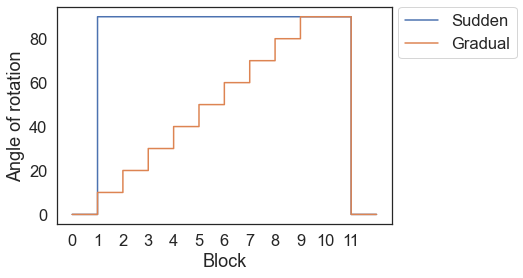

In [36]:
sns.set(font_scale = 1.5, style = 'white')
g = sns.lineplot(x = 'Block', y = 'Angle of rotation', hue = 'Perturbation Schedule',drawstyle = 'steps-pre', estimator = None, ci = None, data = perturb_sch)
g.set_xticks(range(12))
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('C:\\Users\\Tejas\\OneDrive - University of Massachusetts\\PLoS_comp_bio\\figures\\perturbation_schedule.png', dpi = 600, bbox_inches = 'tight')

In [22]:
def angular_dist(b, a, c):
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    signed_angle = np.arctan2(ba[1],ba[0]) - np.arctan2(bc[1],bc[0])


    return angle, signed_angle

def calc_angular_error(traj):    
    init_error = np.zeros(64)
    online_error = np.zeros(64)
    mean_error = np.zeros(64)
    max_error = np.zeros(64)
    sum_error = np.zeros(64)
    max_vel_error = np.zeros(64)
    signed_angles = np.zeros(64, dtype = object)
    signed_angles_var = np.zeros(64)
    ide = np.zeros(64)
    velocity = calc_velocity(traj)
    for j in range(64):
        traj_ang_errors = list()
        signed_angle = list()
        trajx, trajy = traj['x'][0][j][0].astype(float), traj['y'][0][j][0].astype(float)
        #end_pointx, end_pointy  = square_coord['squareX'][0][j], square_coord['squareY'][0][j]
        end_pointx, end_pointy  = traj['x'][0][j][0][-1], traj['y'][0][j][0][-1]

        xline = np.linspace(0, end_pointx, 500)
        yline = np.linspace(0, end_pointy, 500)

        for i in range(len(trajx) - 1):
            ang_dist = angular_dist(np.array([trajx[i], trajy[i]]), np.array([trajx[i+1], trajy[i+1]]), np.array([trajx[-1], trajy[-1]]))[0]
            traj_ang_errors.append(ang_dist)
        
        for i in range(len(trajx) - 2):
            newx = np.abs(trajx)
            newy = np.abs(trajy)
            signed_angle.append(angular_dist(np.array([newx[i], newy[i]]), np.array([newx[i+1], newy[i+1]]), np.array([newx[-1], newy[-1]]))[1])
        signed_angles[j] = signed_angle
        signed_angles_var[j] = np.var(signed_angle)
        init_error[j] = np.nanmean(traj_ang_errors[:np.argmax(velocity[j])])
        online_error[j] = np.nanmean(traj_ang_errors[np.argmax(velocity[j]):])
        max_vel_error[j] = traj_ang_errors[np.argmax(velocity[j])]
        max_error[j] = np.nanmax(traj_ang_errors)
        mean_error[j] = np.nanmean(traj_ang_errors)
        try:
            ide[j] = angular_dist(np.zeros(2), np.array([trajx[np.argmax(velocity[j][1:-1])+1], trajy[np.argmax(velocity[j][1:-1])+1]]), np.array([end_pointx, end_pointy]))[0]
        except:
            print(j)
    return init_error, online_error, max_vel_error, signed_angles_var, max_error, mean_error, ide#, median_error, max_error, error_at_max_vel, error_at_inflection


In [5]:
init_error = np.zeros((60, 12, 64))
online_error = np.zeros((60, 12, 64))
mean_error = np.zeros((60, 12, 64))
max_vel_error = np.zeros((60, 12, 64))
signed_angles_var = np.zeros((60, 12, 64))
max_error = np.zeros((60, 12, 64))
euclidean_mean = np.zeros((60, 12, 64))
ide = np.zeros((60, 12, 64))
AUC = np.zeros((60, 12, 64))
MAD = np.zeros((60, 12, 64))
init_AUC = np.zeros((60, 12, 64))
init_MAD = np.zeros((60, 12, 64))
latter_AUC = np.zeros((60, 12, 64))
latter_MAD = np.zeros((60, 12, 64))


for data in range(1000, 1060):
    print(data)
    for block in range(12):        
        traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data)))
        #init_error[data-1000][block], online_error[data-1000][block], max_vel_error[data-1000][block], signed_angles_var[data-1000][block], max_error[data-1000][block], mean_error[data-1000][block], ide[data-1000][block] = calc_angular_error(traj)
        #euclidean_mean[data - 1000][block] = calc_euclidean(traj)
        AUC[data - 1000][block], MAD[data - 1000][block], init_AUC[data - 1000][block], init_MAD[data - 1000][block], latter_AUC[data - 1000][block], latter_MAD[data - 1000][block]= calc_error(traj)

1000
41
1001
1002
1003
1004
1005
1006
1007
1008
3
1009
1010
1011
1012
2
46
1013
1014
1015
1016
1017
1018
1019
33
50
26
1020
1021
1022
15
1023
1024
1025
1026
1027
1028
12
46
1029
1030
55
1031
1032
1033
1034
1035
1036
19
1037
49
16
1038
34
49
1039
1040
1041
1042
6
30
6
62
36
1043
1044
58
1045
1046
1047
51
1048
50
54
1049
28
1050
31
1051
1052
37
1053
1054
53
55
1055
1056
1057
11
1058
1059


In [812]:
data = 1008
block = 4
traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data)))
a, b, c, d, e, f, id_e = calc_angular_error(traj)

<ipython-input-810-34b4df2f7025>:4: RuntimeWarning: invalid value encountered in double_scalars
  cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
<ipython-input-810-34b4df2f7025>:5: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)
<ipython-input-810-34b4df2f7025>:42: RuntimeWarning: Mean of empty slice
  init_error[j] = np.nanmean(traj_ang_errors[:np.argmax(velocity[j])])


In [9]:
auc_smooth = np.zeros((60, 12, 64))
mad_smooth = np.zeros((60, 12, 64))
avg_smooth = np.zeros((60, 12, 64))
avg = np.zeros((60, 12, 64))
for participant in range(60):
    for block in range(12):
        #AUC[participant][block] = np.nan_to_num(AUC[participant][block], nan = np.nanmedian(AUC[participant][block]))
        #auc_smooth[participant][block] = gaussian_filter(AUC[participant][block], sigma = 2)
        avg[participant][block] = np.nan_to_num(average[participant][block], nan = np.nanmedian(average[participant][block]))
        avg_smooth[participant][block] = gaussian_filter(avg[participant][block], sigma = 2)
        
        #MAD[participant][block] = np.nan_to_num(MAD[participant][block], nan = np.nanmedian(MAD[participant][block]))
        #mad_smooth[participant][block] = gaussian_filter(MAD[participant][block], sigma = 2)
        


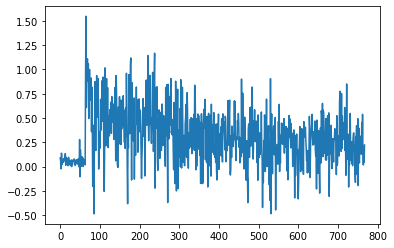

In [42]:
e = pickle.load(open('mean_drawn_grouperrors.pickle', 'rb'))

plt.plot(np.ravel(es[1][3]))

In [19]:
pickle.dump(avg_smooth, open('avg_smooth.pickle', 'wb'))

In [5]:
ide_smooth = pickle.load(open('ide_smooth.pickle', 'rb'))

0.27419354838709675

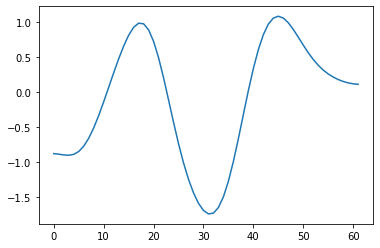

In [813]:
trial = 16
plt.plot(gaussian_filter(signed_angles[trial], sigma=4))
np.nanmean(signed_angles[trial])
find_peaks(gaussian_filter(signed_angles[trial], sigma=4), height=0.5)[0][0]/len(signed_angles[trial])

In [3]:
# ide_smooth = pickle.load(open('ide_smooth.pickle', 'rb'))
# auc_smooth = pickle.load(open('auc_smooth.pickle', 'rb'))
# mad_smooth = pickle.load(open('mad_smooth.pickle', 'rb'))
avg_smooth = pickle.load(open('avg_smooth.pickle', 'rb'))


FileNotFoundError: [Errno 2] No such file or directory: 'avg_smooth.pickle'

In [3]:
average = pickle.load(open('curvatures.pickle', 'rb'))

In [36]:
pickle.dump(auc_smooth, open('auc_smooth.pickle', 'wb'))
pickle.dump(mad_smooth, open('mad_smooth.pickle', 'wb'))

In [4]:
error_measures = pd.DataFrame({'Participant_Id': np.repeat(range(60), 768),
                       'Trial': np.tile(np.arange(768), 60),
                       'Block': np.tile(np.repeat(np.arange(12), 64), 60), 
                       'Rotation': np.tile(np.repeat(np.array(['Sudden', 'Sudden', 'Gradual', 'Gradual']), 768), 15),
                       'Emphasis': np.tile(np.repeat(np.array(['Speed', 'Accuracy']), 768), 30),
                       #'aiming_error': np.ravel(init_error),
                       #'online_error': np.ravel(online_error),
                       #'Max_Vel_Error': np.ravel(max_vel_error),
                       #'Max_Error': np.ravel(max_error),
                       #'Mean_Error': np.ravel(mean_error),
                       #'Current': np.ravel(curvatures_smooth)
                       #'Euclidean_Mean': np.ravel(euclidean_mean)
                       #'total_error': np.ravel(ide) + np.ravel(online_error),
                       #'ide': np.ravel(ide_smooth)/np.max(ide_smooth),
                       #'AUC': np.ravel(auc_smooth)/np.max(auc_smooth),
                       #'MAD': np.ravel(mad_smooth)/np.max(mad_smooth),
                       'average': np.ravel(avg_smooth)/90
                       #'init_AUC': np.ravel(init_AUC)/np.max(init_AUC),
                       #'init_MAD': np.ravel(init_MAD)/np.max(init_MAD),
                       #'late_AUC': np.ravel(latter_AUC)/np.max(latter_AUC),
                       #'late_MAD': np.ravel(latter_MAD)/np.max(latter_MAD)
                       #'Signed_Angle_Var': np.ravel(signed_angles_var)
                      })
error_measures['Condition'] = error_measures['Rotation'] + '_' + error_measures['Emphasis']

In [16]:
#Saving group average curvatures
group_avg_curvatures = np.zeros((4, 12, 64))
for group in range(4):
    group_avg_curvatures[group] = np.mean(avg_smooth[group::4], axis = 0)


In [18]:
pickle.dump( group_avg_curvatures, open('group_avg_curvatures.pickle', 'wb'),)

(4, 12, 64)

In [24]:
groupmean_avg_error = error_measures.groupby(['Trial', 'Block', 'Rotation', 'Emphasis', 'Condition']).mean().reset_index()
groupmean_avg_error['std'] = error_measures.groupby(['Trial', 'Block', 'Rotation', 'Emphasis', 'Condition']).std().reset_index()['average']


In [26]:
groupmean_avg_error.to_csv('group_mean_avg_error.csv')

In [6]:
curvatures_smooth = pickle.load(open('ide_smooth.pickle', 'rb'))

In [31]:
e_m = mad_smooth
block10_11 = pd.DataFrame({'Participant_Id': np.repeat(range(60), 64),
                           'Trial': np.tile(np.arange(64), 60),
                           '10_MAD': np.ravel(mad_smooth[:, 10, :])/np.max(mad_smooth),
                           '10_IDE': np.ravel(ide_smooth[:, 10, :])/np.max(ide_smooth),
                           '10_AUC': np.ravel(auc_smooth[:, 10, :])/np.max(auc_smooth),
                           '10_AVG': np.ravel(avg_smooth[:, 10, :])/np.max(avg_smooth),
                           '11_MAD':np.ravel(mad_smooth[:, 11, :])/np.max(mad_smooth),
                           '11_IDE':np.ravel(ide_smooth[:, 11, :])/np.max(ide_smooth),
                           '11_AUC':np.ravel(auc_smooth[:, 11, :])/np.max(auc_smooth),
                           '11_AVG':np.ravel(avg_smooth[:, 11, :])/np.max(avg_smooth),
                           'Rotation': np.tile(np.repeat(np.array(['Sudden', 'Sudden', 'Gradual', 'Gradual']), 64), 15),
                           'Emphasis': np.tile(np.repeat(np.array(['Speed', 'Accuracy']), 64), 30),
                          })
block10_11['Condition'] = block10_11['Rotation'] + '_' + block10_11['Emphasis']
block10_11['10-11_MAD'] = block10_11['10_MAD'] - block10_11['11_MAD']
block10_11['10-11_AUC'] = block10_11['10_AUC'] - block10_11['11_AUC']
block10_11['10-11_IDE'] = block10_11['10_IDE'] - block10_11['11_IDE']
block10_11['10-11_AVG'] = block10_11['10_AVG'] - block10_11['11_AVG']


block10_11_blockwise = block10_11.groupby(['Participant_Id', 'Rotation', 'Emphasis', 'Condition']).median().reset_index()
block10_11_melt = block10_11_blockwise.melt(id_vars=['Participant_Id', 'Trial', 'Rotation', 'Emphasis', 'Condition'], var_name = 'Block', value_name = 'Error')


In [32]:
block10_11_melt

,Participant_Id,Trial,Rotation,Emphasis,Condition,Block,Error
0,0,31.5,Sudden,Speed,Sudden_Speed,10_MAD,0.285846
1,1,31.5,Sudden,Accuracy,Sudden_Accuracy,10_MAD,0.032090
2,2,31.5,Gradual,Speed,Gradual_Speed,10_MAD,0.095062
3,3,31.5,Gradual,Accuracy,Gradual_Accuracy,10_MAD,0.023370
4,4,31.5,Sudden,Speed,Sudden_Speed,10_MAD,0.146153
...,...,...,...,...,...,...,...
715,55,31.5,Gradual,Accuracy,Gradual_Accuracy,10-11_AVG,0.002508
716,56,31.5,Sudden,Speed,Sudden_Speed,10-11_AVG,0.163062
717,57,31.5,Sudden,Accuracy,Sudden_Accuracy,10-11_AVG,0.013108
718,58,31.5,Gradual,Speed,Gradual_Speed,10-11_AVG,-0.113904


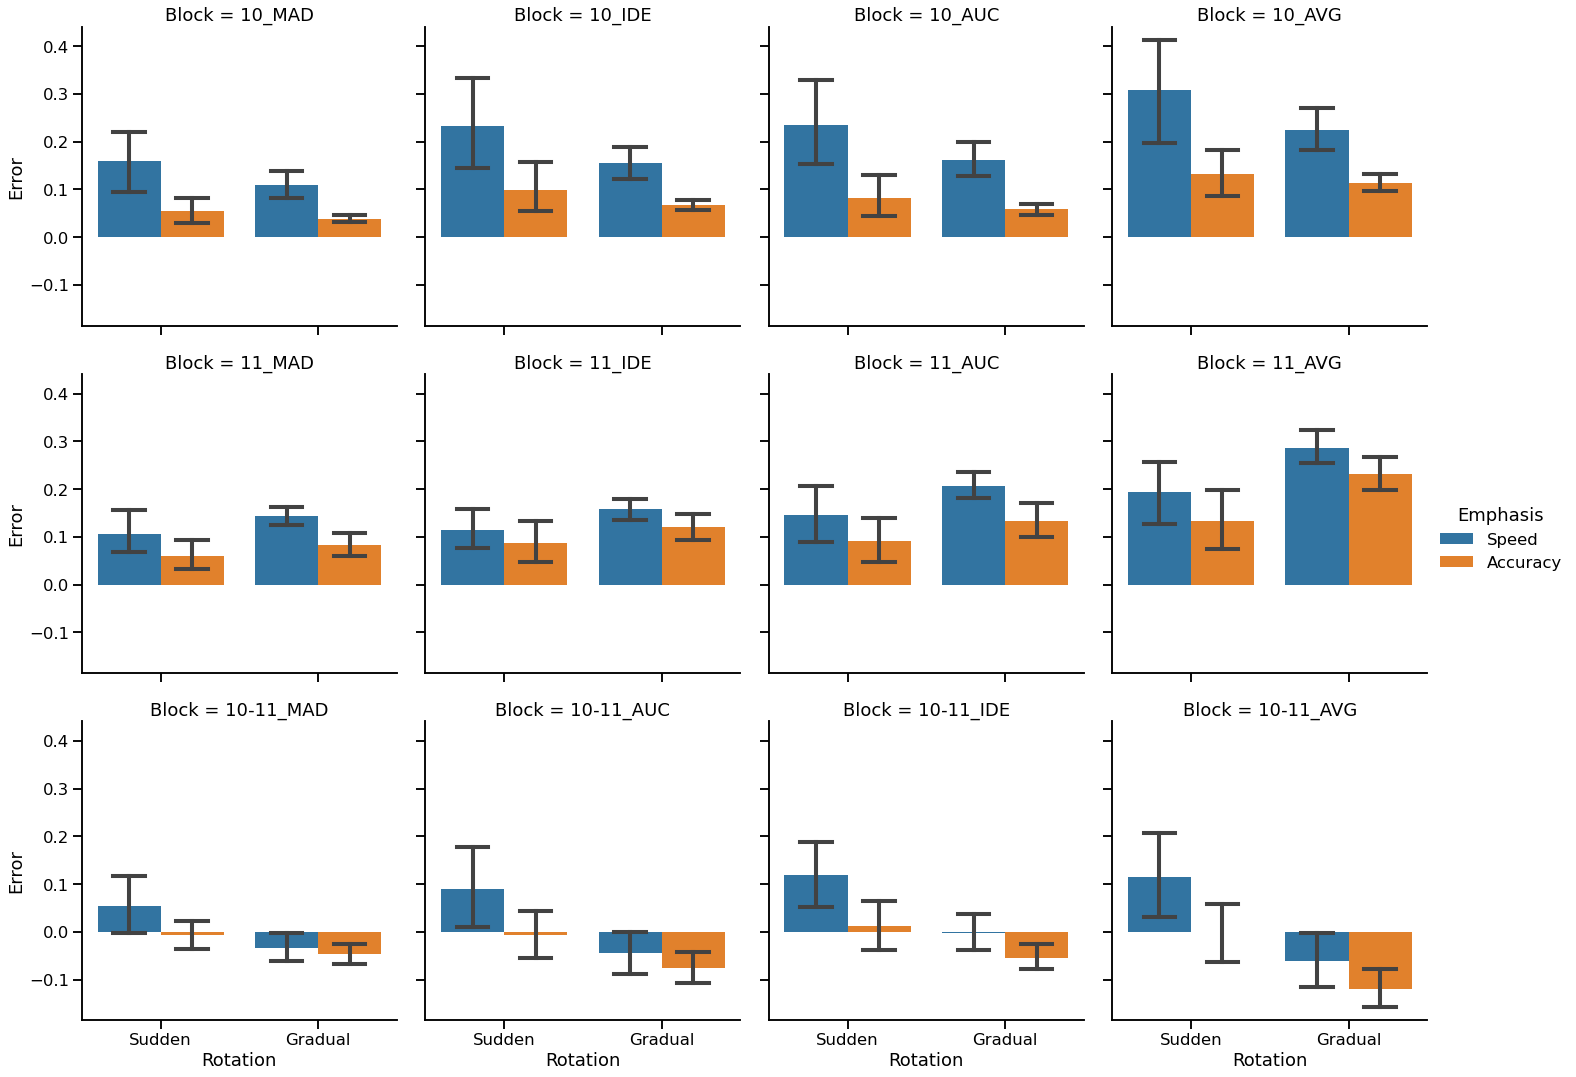

In [18]:
sns.set_context('talk')
sns.catplot(x = 'Rotation', y = 'Error', hue = 'Emphasis', col = 'Block' , col_wrap = 4,
            data = block10_11_melt, kind = 'bar', capsize = 0.2)


In [36]:
model = smf.ols('Error~Rotation*Emphasis*Block', 
                data = block10_11_melt.loc[block10_11_melt['Block'] == '10_AVG']).fit()
aov = sm.stats.anova_lm(model, typ = 2)
aov

SyntaxError: invalid syntax (<ipython-input-36-5615dd5ac35b>, line 2)

In [5]:
errors_melt = error_measures.melt(id_vars=['Participant_Id', 'Trial', 'Block', 'Rotation', 'Emphasis', 'Condition'], var_name='Error_Type', value_name='Errors')

In [6]:
blockwise = errors_melt.groupby(['Participant_Id', 'Block', 'Error_Type', 'Rotation', 'Emphasis', 'Condition']).median().reset_index()


In [10]:
model = smf.ols('Errors~Rotation*Emphasis*Block', 
                data = blockwise[blockwise['Block'].isin([10, 11])]).fit()
aov = sm.stats.anova_lm(model, typ = 2)
aov

,sum_sq,df,F,PR(>F)
Rotation,0.075632,1.0,1.962292,0.164033
Emphasis,0.720569,1.0,18.695361,0.000033
Rotation:Emphasis,0.009568,1.0,0.248240,0.619294
Block,0.003460,1.0,0.089775,0.765019
Rotation:Block,0.419758,1.0,10.890729,0.001297
Emphasis:Block,0.185389,1.0,4.809965,0.030363
Rotation:Emphasis:Block,0.031212,1.0,0.809792,0.370112
Residual,4.316777,112.0,NaN,NaN


In [8]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style = 'white', context = 'talk', rc=custom_params)

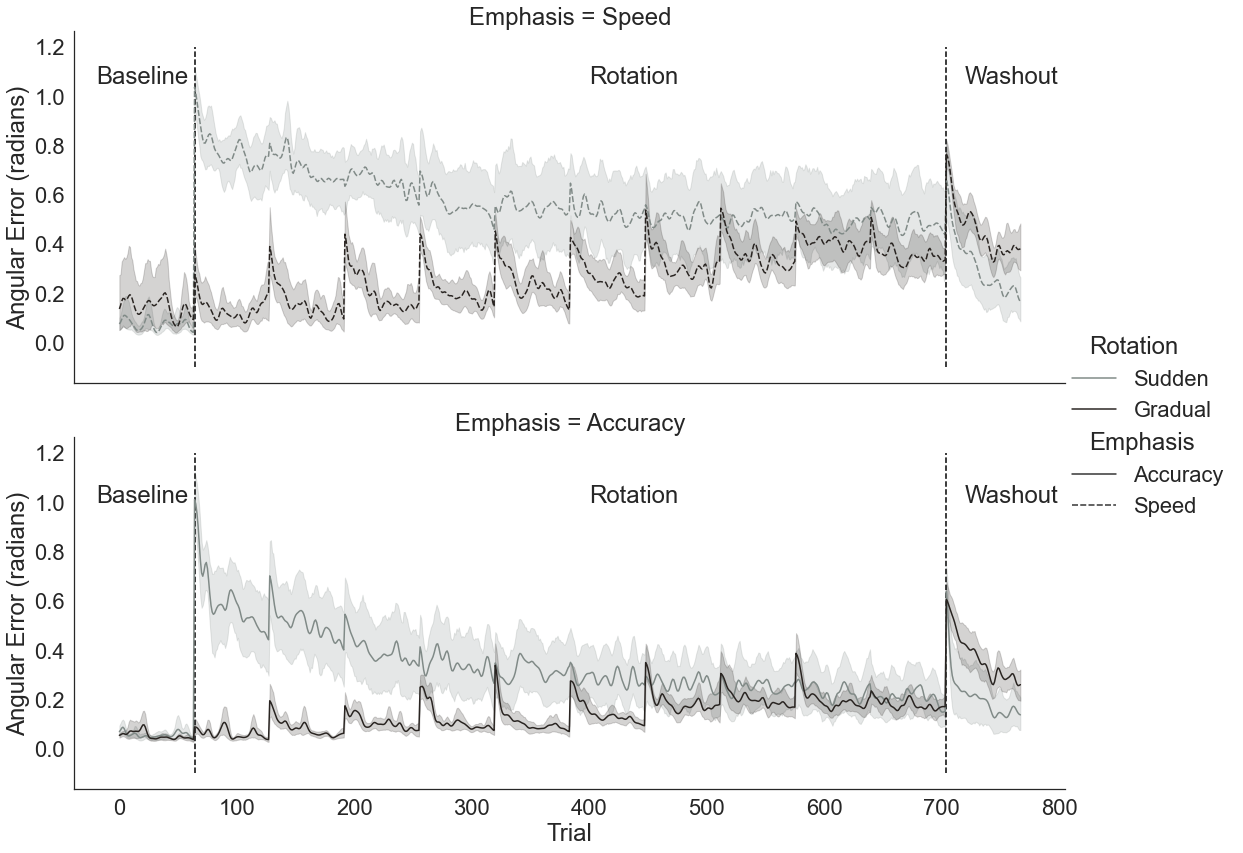

In [73]:
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#808A87', '#292421']
sns.set_palette(sns.color_palette(colors))

g = sns.relplot(x = 'Trial', y = 'Errors', hue = 'Rotation', row = 'Emphasis', style='Emphasis', 
                 style_order=['Accuracy', 'Speed'],
            data = errors_melt[errors_melt['Error_Type'] == 'average'], height = 6, aspect = 2.5, kind = 'line')
g.set_axis_labels('Trial', 'Angular Error (radians)')

# draw lines:
for ax in g.axes.ravel():
    ax.vlines(x = 64, ymax=1.2, ymin = -0.1, color = 'black', linestyles = '--')
    ax.vlines(x = 704, ymax=1.2, ymin = -0.1, color = 'black', linestyles = '--')

#plt.vlines(x = 64, ymax=1.2, ymin = -0.1, color = 'black', linestyles = '--')
#plt.vlines(x = 704, ymax=1.2, ymin = -0.1, color = 'black', linestyles = '--')
plt.text(x = -20, y = 1, s = 'Baseline')
plt.text(x = 400, y = 1, s = 'Rotation')
plt.text(x = 720, y = 1, s = 'Washout')

plt.text(x = -20, y = 2.7, s = 'Baseline')
plt.text(x = 400, y = 2.7, s = 'Rotation')
plt.text(x = 720, y = 2.7, s = 'Washout')

sns.despine(bottom=False, left=False)
plt.savefig('C:\\Users\\Tejas\\OneDrive - University of Massachusetts\\PLoS_comp_bio\\figures\\Trial_data_all_conditions.png', dpi = 600, bbox_inches = 'tight')

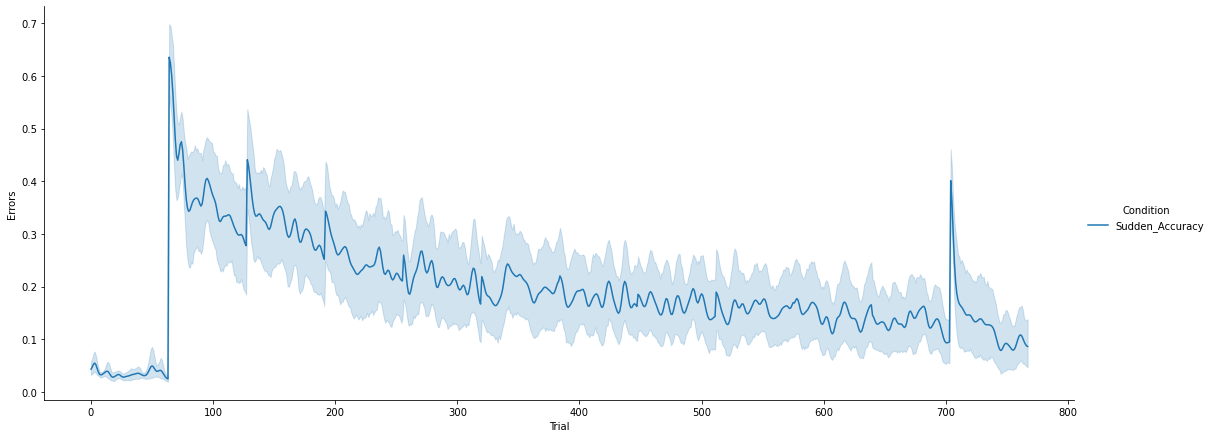

In [9]:
sns.relplot(x = 'Trial', y = 'Errors', hue = 'Condition', 
            data = errors_melt, height = 6, aspect = 2.5, kind = 'line')


In [4]:
errors = pd.read_csv('curvature_errors_all.csv')
errors['Condition'] = errors['rotation'] + '_' + errors['emphasis']

In [18]:
sns.relplot(x = 'Trial', y = 'Errors', col = 'Error_Type', hue = 'Condition', data = errors_melt.loc[(errors_melt['Block'] == 10) | (errors_melt['Block'] == 11)], 
            kind = 'line')

NameError: name 'errors_melt' is not defined

In [6]:
block_wise = errors.groupby(['participant_id', 'block_no', 'rotation', 'emphasis', 'Condition']).mean().reset_index()

,participant_id,block_no,rotation,emphasis,Condition,Unnamed: 0,trial_no,errors
0,0,0,Sudden,Accuracy,Sudden_Accuracy,31.5,31.5,1.222246
1,0,1,Sudden,Accuracy,Sudden_Accuracy,95.5,95.5,0.669200
2,0,2,Sudden,Accuracy,Sudden_Accuracy,159.5,159.5,0.320817
3,0,3,Sudden,Accuracy,Sudden_Accuracy,223.5,223.5,0.259095
4,0,4,Sudden,Accuracy,Sudden_Accuracy,287.5,287.5,0.300717
...,...,...,...,...,...,...,...,...
763,63,7,Gradual,Speed,Gradual_Speed,48863.5,479.5,1.124124
764,63,8,Gradual,Speed,Gradual_Speed,48927.5,543.5,1.277725
765,63,9,Gradual,Speed,Gradual_Speed,48991.5,607.5,1.365361
766,63,10,Gradual,Speed,Gradual_Speed,49055.5,671.5,1.497375


In [12]:
model = smf.ols('errors~block_no*rotation*emphasis', data = block_wise.loc[(block_wise['block_no'] == 10) | (block_wise['block_no'] == 11)]).fit()
aov = sm.stats.anova_lm(model, typ = 2)
aov

,sum_sq,df,F,PR(>F)
rotation,0.027429,1.0,0.380425,0.538544
emphasis,0.633076,1.0,8.780526,0.003672
rotation:emphasis,0.088241,1.0,1.223867,0.270816
block_no,1.018426,1.0,14.125199,0.000266
block_no:rotation,0.054765,1.0,0.759575,0.385202
block_no:emphasis,0.362393,1.0,5.026255,0.026803
block_no:rotation:emphasis,0.092644,1.0,1.284934,0.259243
Residual,8.651996,120.0,NaN,NaN


In [13]:
0.054/(0.027429+0.633076+0.088241+1.018426+0.362393+0.092644+8.651996)

0.004965880264350359

In [14]:
0.78* (3/ 61)

0.03836065573770492

In [7]:
model = smf.ols('Errors~Block*Emphasis', data = block_wise).fit()
aov = sm.stats.anova_lm(model, typ = 2)
aov

PatsyError: Error evaluating factor: NameError: name 'Emphasis' is not defined
    Errors~Block*Emphasis
                 ^^^^^^^^

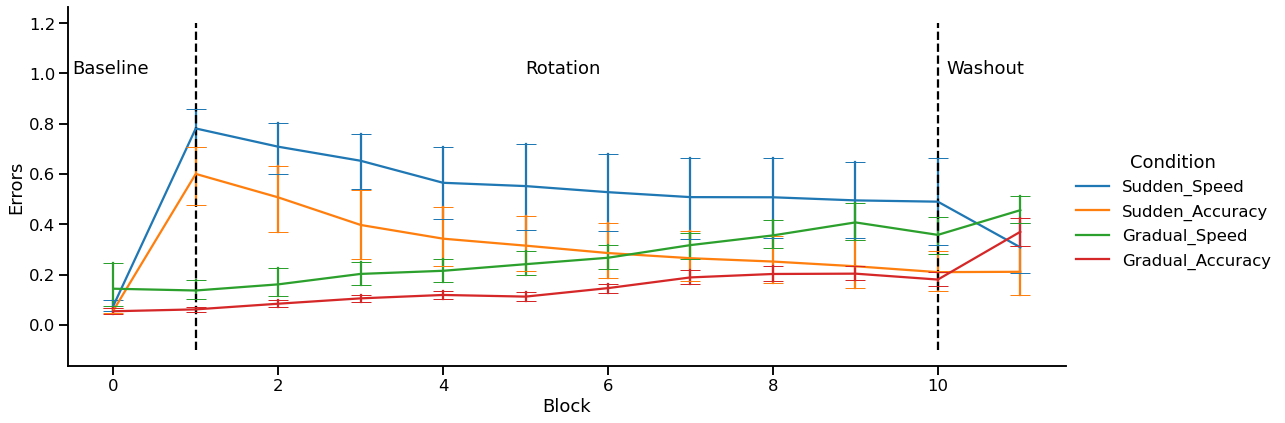

In [19]:
sns.set_context('talk')
sns.relplot(x = 'Block', y = 'Errors', hue = 'Condition',
            data = block_wise, height = 6, aspect = 2.5, kind = 'line', markers = True, 
            err_style = 'bars', err_kws = {"capsize": 10})

plt.vlines(x = 1, ymax=1.2, ymin = -0.1, color = 'black', linestyles = '--')
plt.vlines(x = 10, ymax=1.2, ymin = -0.1, color = 'black', linestyles = '--')
plt.text(x = -0.5, y = 1, s = 'Baseline')
plt.text(x = 5, y = 1, s = 'Rotation')
plt.text(x = 10.1, y = 1, s = 'Washout')
sns.despine(bottom=False, left=False)
plt.savefig('C:\\Users\\Tejas\\OneDrive - University of Massachusetts\\PLoS_comp_bio\\figures\\block_data_all_conditions.png', dpi = 600, bbox_inches = 'tight')

Text(0.5, 1.296084092416878, 'Block 11 \n (Washout Block)')

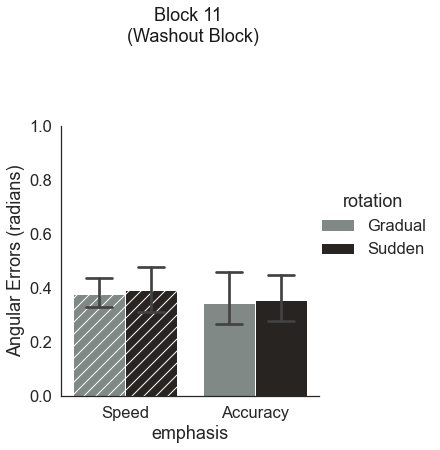

In [20]:
from itertools import cycle
#sns.set_context('paper')
sns.set(font_scale = 1.5)
sns.set_style('white')
colors = [ '#808A87', '#292421']
#'#D3D3D3',
sns.set_palette(sns.color_palette(colors))

g = sns.catplot(x = 'emphasis', y = 'errors', hue = 'rotation', hue_order=['Gradual', 'Sudden'], order = ['Speed', 'Accuracy'],
            data = block_wise.loc[(block_wise['block_no'] == 11)],  capsize = 0.2, kind = 'bar')
g.set(ylabel='Angular Errors (radians)')
#x1, x2 = 0.8, 1.2
#y, h, col = block_wise.loc[(block_wise['Block'] == 10)]['Errors'].max()-0.3, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)

hatches = ['//', '', '//', '']
num_locations = len(block_wise.rotation.unique())
for i, patch in enumerate(g.ax.patches):
    #if i % num_locations == 0:
    #print(i)
    #print(patch)
    patch.set_hatch(hatches[i])
x1, x2 = 0, 1
y, h, col = block_wise.loc[(block_wise['block_no'] == 10)]['errors'].max()-0.5, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
# plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
plt.ylim((0, 1))

#x1, x2 = -0.2, 0.2
#y, h, col = block_wise.loc[(block_wise['Block'] == 10)]['Errors'].max()-0.3, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
plt.text(0.5, y+h+0.15, "Block 11 \n (Washout Block)", ha='center', va='bottom', color=col)
# plt.savefig('C:\\Users\\Tejas\\OneDrive - University of Massachusetts\\PLoS_comp_bio\\figures\\block10_bar.png', dpi = 600, bbox_inches = 'tight')

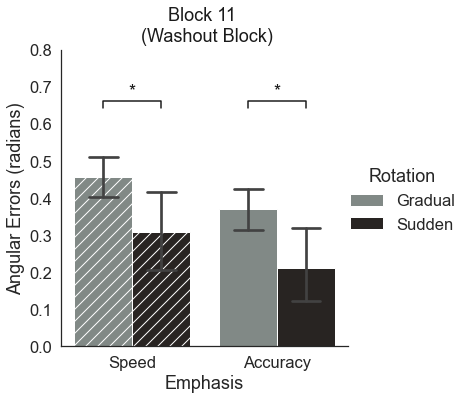

In [70]:
sns.set(font_scale = 1.5)
sns.set_style('white')
colors = [ '#808A87', '#292421']
#'#D3D3D3',
sns.set_palette(sns.color_palette(colors))
g = sns.catplot(x = 'Emphasis', y = 'Errors', hue = 'Rotation', hue_order=['Gradual', 'Sudden'],
            data = block_wise.loc[(block_wise['Block'] == 11)], kind = 'bar', capsize = 0.2)
plt.ylim((0, 0.8))
g.set(ylabel='Angular Errors (radians)')
#x1, x2 = 0, 1
#y, h, col = block_wise.loc[(block_wise['Block'] == 11)]['Errors'].max()-0.2, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)

x1, x2 = 0.8, 1.2
y, h, col = block_wise.loc[(block_wise['Block'] == 11)]['Errors'].max()-0.1, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)

x1, x2 = -0.2, 0.2
y, h, col = block_wise.loc[(block_wise['Block'] == 11)]['Errors'].max()-0.1, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)

hatches = ['//', '', '//', '']
num_locations = len(block_wise.Rotation.unique())
for i, patch in enumerate(g.ax.patches):
    #if i % num_locations == 0:
    #print(i)
    #print(patch)
    patch.set_hatch(hatches[i])


plt.text(0.5, y+h+0.15, "Block 11 \n (Washout Block)", ha='center', va='bottom', color=col)
plt.savefig('C:\\Users\\Tejas\\OneDrive - University of Massachusetts\\PLoS_comp_bio\\figures\\block11_bar.png', dpi = 600, bbox_inches = 'tight')

In [3]:
rts = pd.read_csv('RTs.csv')
rts['TTs'] = rts['ITs']+rts['MTs']
rts_blockwise = rts.groupby(['Participant_Id', 'Block', 'Rotation', 'Emphasis']).mean().reset_index()
rts_mean = rts.groupby(['Participant_Id', 'Rotation', 'Emphasis']).median().reset_index()



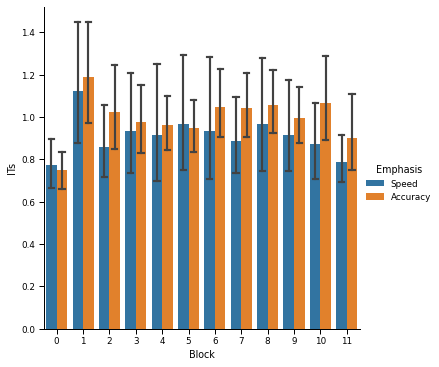

In [80]:
sns.catplot(x = 'Block', hue = 'Emphasis', y = 'ITs',  data = rts_blockwise, capsize = 0.2, kind = 'bar')

In [6]:
stat.ttest_ind(rts_mean[rts_mean['Emphasis'] == 'Speed']['ITs'], rts_mean[rts_mean['Emphasis'] == 'Accuracy']['ITs'])

Ttest_indResult(statistic=-0.859657123465156, pvalue=0.39351742786572563)

In [83]:
model = smf.ols('MTs~Rotation*Emphasis', data = rts_mean).fit()
aov = sm.stats.anova_lm(model, typ = 2)
aov

,sum_sq,df,F,PR(>F)
Rotation,0.050462,1.0,0.332748,0.566357
Emphasis,0.727949,1.0,4.800128,0.032636
Rotation:Emphasis,0.022772,1.0,0.150157,0.699855
Residual,8.492512,56.0,NaN,NaN


([<matplotlib.axis.YTick at 0x2519e4408b0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

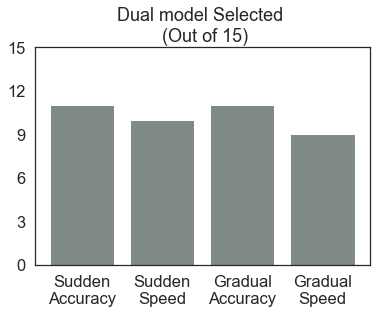

In [27]:
plt.bar(x=['Sudden\nAccuracy', 'Sudden\nSpeed', 'Gradual\nAccuracy', 'Gradual\nSpeed'], height = [11, 10, 11, 9])
plt.title('Dual model Selected \n (Out of 15)')
plt.yticks([0, 3, 6, 9, 12, 15])